# Exercises

> **Note**: These exercises expect the use of `torchvision` v0.13+ (released July 2022), previous versions may work but will likely have errors.

All of the exercises are focused on practicing the code above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).

## 0. Prerequisites

- Load libraries
- Load scripts
- Load data

In [2]:
# import libraries
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# try to get torchinfo
try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

# try to import the going_modular directory and helper_functions sciprts
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    !git clone https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course
    !mv PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/going_modular .
    !mv PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/helper_functions.py .
    !rm -rf PyTorch-for-Deep-Learning-Machine-Learning-Full-Course
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

Cloning into 'PyTorch-for-Deep-Learning-Machine-Learning-Full-Course'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 155 (delta 45), reused 66 (delta 27), pack-reused 56
Receiving objects: 100% (155/155), 49.89 MiB | 22.22 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [11]:
# setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_path = download_data(source='https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/raw/main/data/pizza_steak_sushi.zip',
                           destination='pizza_steak_sushi')

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


In [12]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [13]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [14]:
from IPython.testing import test
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=BATCH_SIZE)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f631df2d4b0>,
 ['pizza', 'steak', 'sushi'])

In [15]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

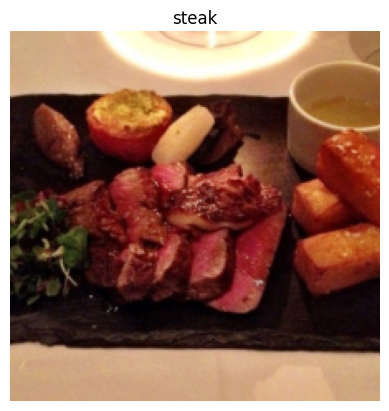

In [16]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers)

- You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
- You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [17]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        x = self.patcher(x)
        x = self.flatten(x)
        return x.permute(0, 2, 1)

In [26]:
class ViT(nn.Module):
    def __init__(self,
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768,
                 embedding_dropout: float=0.1,
                 d_model: int=768,
                 nhead: int=12,
                 dim_feedforward: int=3072,
                 activation: str="gelu",
                 dropout: float=0.1,
                 batch_first: bool=True,
                 norm_first: bool=True,
                 num_layers: int=12,
                 num_classes: int=1000
                 ):
        super().__init__()
        self.num_patches = (img_size * img_size) // patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.rand(1, self.num_patches + 1, embedding_dim),
                                               requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=d_model,                  # Create a single transformer encoder
                                                                                                  nhead=nhead,
                                                                                                  dim_feedforward=dim_feedforward,
                                                                                                  activation=activation,
                                                                                                  dropout=dropout,
                                                                                                  batch_first=batch_first,
                                                                                                  norm_first=norm_first),
                                                        num_layers=num_layers)                                                      # stack the encoder N times
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                        nn.Linear(in_features=embedding_dim,
                                                  out_features=num_classes))

    def forward(self, x):
        batch_size = x.shape[0]                                         # get the batch size from x
        class_token = self.class_embedding.expand(batch_size, -1, -1)   # expand the class token across the batch size
        x = self.patch_embedding(x)                                     # create the patch embedding
        x = torch.cat((class_token, x), dim=1)                          # prepend the class token to the patch embedding
        x = self.position_embedding + x                                 # add the position embedding to the patch embedding with class token
        x = self.embedding_dropout(x)                                   # apply dropout on patch + positional embedding
        x = self.transformer_encoder(x)                                 # pass embedding through transformer encoder stack
        x = self.classifier(x[:, 0])                                    # pass 0th index of x through MLP head
        return x

In [27]:
# test to see if the model is correct
summary(model=ViT(),
        input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`

- You should be able to import an entire ViT model using something like `from vit import ViT`.

In [28]:
%%writefile vit.py
import torch
from torch import nn

class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        x = self.patcher(x)
        x = self.flatten(x)
        return x.permute(0, 2, 1)

class ViT(nn.Module):
    def __init__(self,
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768,
                 embedding_dropout: float=0.1,
                 d_model: int=768,
                 nhead: int=12,
                 dim_feedforward: int=3072,
                 activation: str="gelu",
                 dropout: float=0.1,
                 batch_first: bool=True,
                 norm_first: bool=True,
                 num_layers: int=12,
                 num_classes: int=1000
                 ):
        super().__init__()
        self.num_patches = (img_size * img_size) // patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.rand(1, self.num_patches + 1, embedding_dim),
                                               requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=d_model,                  # Create a single transformer encoder
                                                                                                  nhead=nhead,
                                                                                                  dim_feedforward=dim_feedforward,
                                                                                                  activation=activation,
                                                                                                  dropout=dropout,
                                                                                                  batch_first=batch_first,
                                                                                                  norm_first=norm_first),
                                                        num_layers=num_layers)                                                      # stack the encoder N times
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                        nn.Linear(in_features=embedding_dim,
                                                  out_features=num_classes))

    def forward(self, x):
        batch_size = x.shape[0]                                         # get the batch size from x
        class_token = self.class_embedding.expand(batch_size, -1, -1)   # expand the class token across the batch size
        x = self.patch_embedding(x)                                     # create the patch embedding
        x = torch.cat((class_token, x), dim=1)                          # prepend the class token to the patch embedding
        x = self.position_embedding + x                                 # add the position embedding to the patch embedding with class token
        x = self.embedding_dropout(x)                                   # apply dropout on patch + positional embedding
        x = self.transformer_encoder(x)                                 # pass embedding through transformer encoder stack
        x = self.classifier(x[:, 0])                                    # pass 0th index of x through MLP head
        return x

Writing vit.py


In [29]:
# test to see if the script works
from vit import ViT

imported_model = ViT()
summary(model=imported_model,
        input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)

- See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16)

- **Note**: ViT pretrained with SWAG weights has a minimum input image size of `(384, 384)` (the pretrained ViT in exercise 3 has a minimum input size of `(224, 224))`, though this is accessible in the weights `.transforms()` method.

## 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things. Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:

- ImageNet-22k pretraining (more data).
- Learning rate warmup.
- Learning rate decay.
- Gradient clipping.